# Pulse-shaping Basics
In this tutorial notebook, you will learn about various components of Sionna's signal module, such as pulse-shaping filters, windowing functions, as well as layers for up- and down-sampling.

Below is a schematic diagram of the used components and how they connect. For simplicity, we have not added any channel between the pulse-shaping filter and the matched filter.

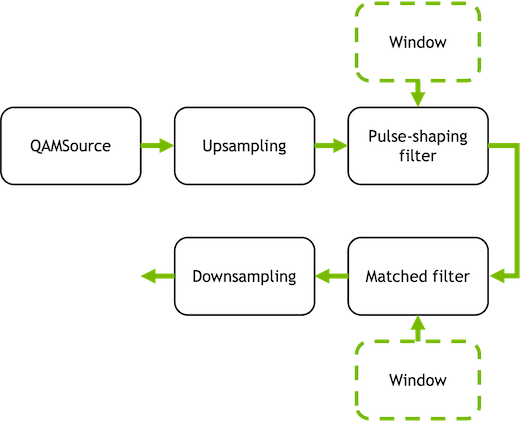

You will learn how to:

* Use filters for pulse-shaping and matched filtering
* Visualize impulse and magnitude responses
* Compute the empirical power spectral density (PSD) and adjacent channel leakage power ratio (ACLR)
* Apply the Upsampling and Downsampling layers
* Add windowing to filters for improved spectral characteristics



## Table of Contents
* [GPU Configuration and Imports](#GPU-Configuration-and-Imports)
* [Pulse-shaping of a sequence of QAM symbols](#Pulse-shaping-of-a-sequence-of-QAM-symbols)
* [Recovering the QAM symbols through matched filtering and downsampling](#Recovering-the-QAM-symbols-through-matched-filtering-and-downsampling)
* [Investigating the ACLR](#Investigating-the-ACLR)
* [Windowing](#Windowing)

## GPU Configuration and Imports

In [1]:
import os
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

# Set random seed for reproducibility
sionna.config.seed = 42

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from sionna.utils import QAMSource
from sionna.signal import Upsampling, Downsampling, RootRaisedCosineFilter, empirical_psd, empirical_aclr

## Pulse-shaping of a sequence of QAM symbols

We start by creating a root-raised-cosine filter with a roll-off factor of 0.22, spanning 32 symbols, with an oversampling factor of four.

In [3]:
beta = 0.22 # Roll-off factor
span_in_symbols = 32 # Filter span in symbold
samples_per_symbol = 4 # Number of samples per symbol, i.e., the oversampling factor
rrcf = RootRaisedCosineFilter(span_in_symbols, samples_per_symbol, beta)

All filters have a function to visualize their impulse response $h(t)$ and magnitude response $H(f)$, i.e., the absolute value of the Fourier transform of $h(t)$. The symbol duration is denoted $T$ and the bandwidth $W$. The *normalized time* and *normalized frequency* are then defined as $t/T$ and $f/W$, respectively.

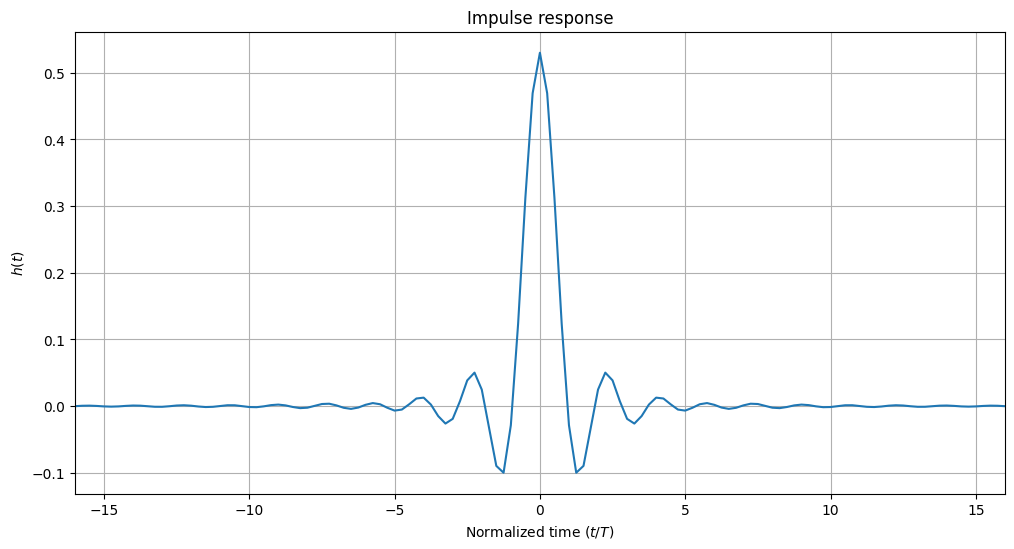

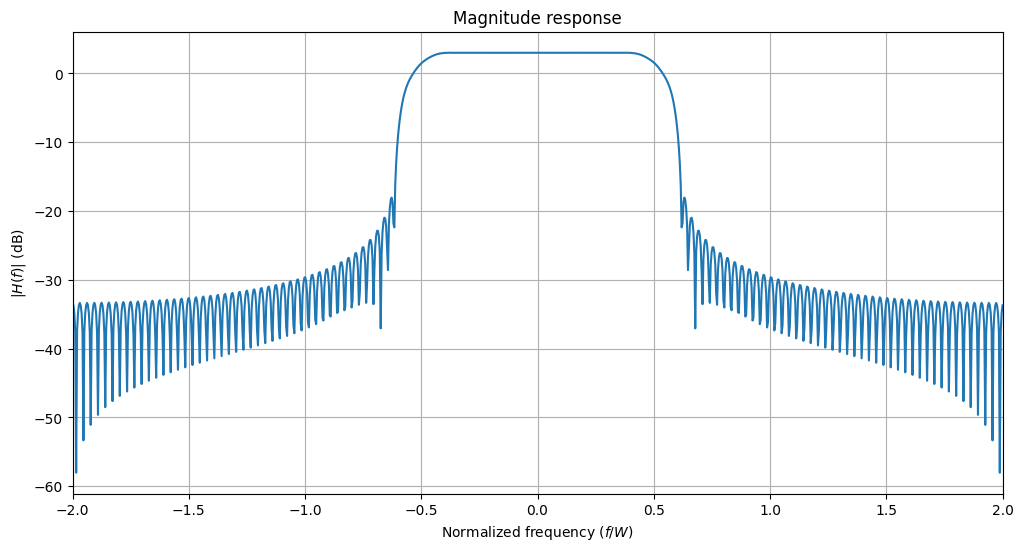

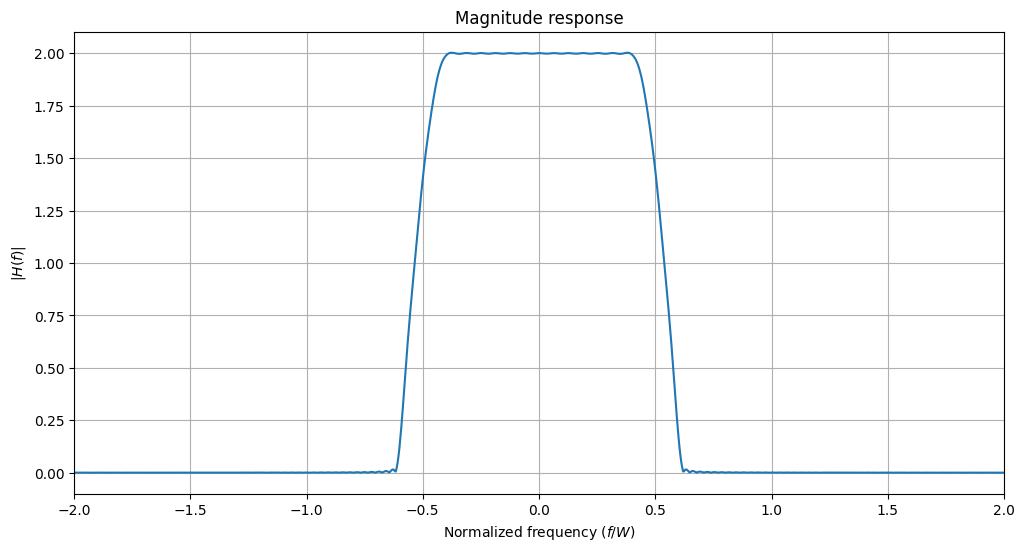

In [4]:
rrcf.show("impulse")
rrcf.show("magnitude", "db") # Logarithmic scale
rrcf.show("magnitude", "lin") # Linear scale

In Sionna, filters have always an odd number of samples. This is despite the fact that the product *span_in_symbols* $\times$ *samples_per_symbol* can be even. Let us verify the length property of our root-raised-cosine filter:

In [5]:
print("Filter length:", rrcf.length)

Filter length: 129


Next, we will use this filter to pulse shape a sequence of QAM symbols. This requires upsampling of the sequence to the desired sampling rate. The sampling rate is defined as the number of samples per symbol $k$, and upsampling simply means that $k-1$ zeros are inserted after every QAM symbol.

Shape of x (128, 1000)
Shape of x_us (128, 4000)


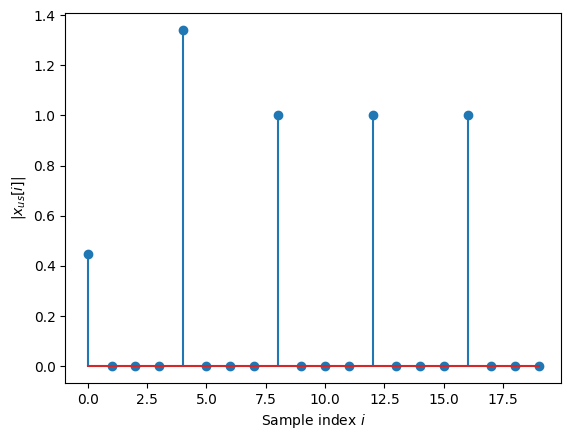

In [6]:
# Configure QAM source
num_bits_per_symbol = 4 # The modulation order of the QAM constellation, i.e., 16QAM
qam = QAMSource(num_bits_per_symbol) # Layer to generate batches of QAM symbols

# Generate batch of QAM symbol sequences
batch_size = 128
num_symbols = 1000
x = qam([batch_size, num_symbols])
print("Shape of x", x.shape)

# Create instance of the Upsampling layer
us = Upsampling(samples_per_symbol)

# Upsample the QAM symbol sequence
x_us = us(x)
print("Shape of x_us", x_us.shape)

# Inspect the first few elements of one row of x_us
plt.stem(np.abs(x_us)[0,:20]);
plt.xlabel(r"Sample index $i$")
plt.ylabel(r"|$x_{us}[i]$|");

After upsampling, we can apply the filter:

In [7]:
# Filter the upsampled sequence
x_rrcf = rrcf(x_us)

## Recovering the QAM symbols through matched filtering and downsampling

In order to recover the QAM symbols from this waveform, we need to apply a matched filter, i.e., the same filter in our case, and downsample the result, starting from the correct index. This index can be obtained as follows. The transmit filter has its peak value after $(L-1)/2$ samples, where $L$ is the filter length. If we apply the same filter for reception, the peak will be delayed by a total of $L-1$ samples. The code in the following cell creates a Downsampling layer that allows us to recover the transmitted symbol sequence.




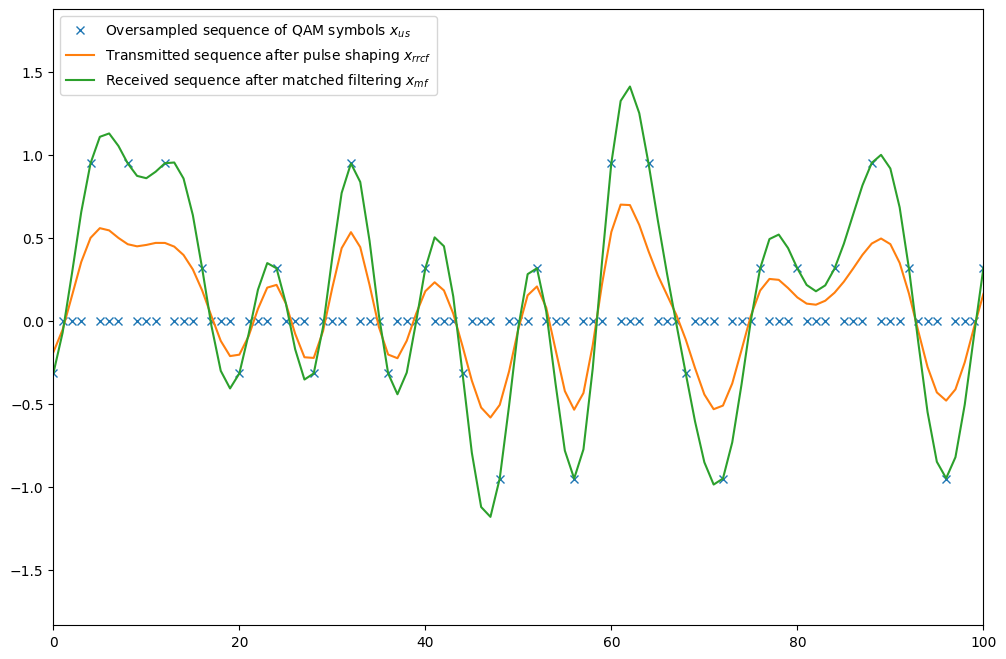

In [8]:
# Apply the matched filter
x_mf = rrcf(x_rrcf)

# Instantiate a downsampling layer
ds = Downsampling(samples_per_symbol, rrcf.length-1, num_symbols)

# Recover the transmitted symbol sequence
x_hat = ds(x_mf)

# Visualize the different signals
plt.figure(figsize=(12, 8))
plt.plot(np.real(x_us[0]), "x")
plt.plot(np.real(x_rrcf[0, rrcf.length//2:]))
plt.plot(np.real(x_mf[0, rrcf.length-1:]));
plt.xlim(0,100)
plt.legend([r"Oversampled sequence of QAM symbols $x_{us}$",
            r"Transmitted sequence after pulse shaping $x_{rrcf}$",
            r"Received sequence after matched filtering $x_{mf}$"]);

We can see nicely from the above figure that the signal after matched filtering overlaps almost perfectly with the oversampled sequence of QAM symbols at the symbol times. As further verification, we will next show a scatter plot of the transmitted and recovered symbols and compute the mean-squared error (MSE) between them. As one can see, the MSE is not zero, which is due to truncation of the filter to finite length. The MSE can be reduced by making the filter longer or by increasing the roll-off factor.

Give it a try and change *span_in_symbols* above to a larger number, e.g., 100. This will reduce the MSE by around 26dB.

MSE between x and x_hat (dB) -53.49393844604492


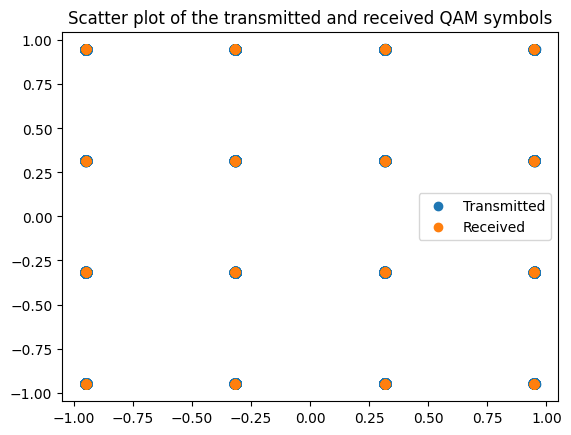

In [9]:
plt.figure()
plt.scatter(np.real(x_hat), np.imag(x_hat));
plt.scatter(np.real(x), np.imag(x));
plt.legend(["Transmitted", "Received"]);
plt.title("Scatter plot of the transmitted and received QAM symbols")
print("MSE between x and x_hat (dB)", 10*np.log10(np.var(x-x_hat)))

## Investigating the ACLR

An important metric of waveforms is the so-called adjacent channel leakage power ratio, or short ACLR. It is defined as the ratio of the out-of-band power and the in-band power. One can get a first idea of the ACLR by looking at the power spectral density (PSD) of a transmitted signal.

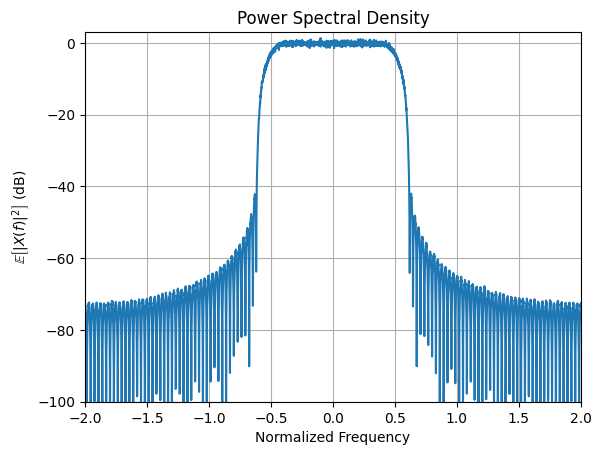

In [10]:
empirical_psd(x_rrcf, oversampling=samples_per_symbol, ylim=[-100, 3]);

The in-band is defined by the interval from [-0.5, 0.5] in normalized frequency. Due to the non-zero roll-of factor, a significant amount of energy is located out of this band. The resulting ACLR can be computed with the following convenience function:

In [11]:
aclr_db = 10*np.log10(empirical_aclr(x_rrcf, oversampling=samples_per_symbol))
print("Empirical ACLR (db):", aclr_db)

Empirical ACLR (db): -13.783864974975586


We can now verify that this empirical ACLR is well aligned with the theoretical ACLR that can be computed based on the magnitude response of the pulse-shaping filter. Every filter provides this value as the property *Filter.aclr*.

In [12]:
print("Filter ACLR (dB)", 10*np.log10(rrcf.aclr))

Filter ACLR (dB) -13.805673122406006


We can improve the ACLR by decreasing the roll-off factor $\beta$ from 0.22 to 0.1:

In [13]:
print("Filter ACLR (dB)", 10*np.log10(RootRaisedCosineFilter(span_in_symbols, samples_per_symbol, 0.1).aclr))

Filter ACLR (dB) -17.3421049118042


## Windowing

Windowing can be used to improve the spectral properties of a truncated filter. For a filter of length $L$, a window is a real-valued vector of the same length that is multiplied element-wise with the filter coefficients. This is equivalent to a convolution of the filter and the window in the frequency domain.

Let us now create a slightly shorter root-raised-cosine filter and compare its properties with and without windowing.
One can see that windowing leads to a much reduced out-of-band attenuation. However, the passband of the filter is also broadened which leads to an even slightly increased ACLR.

ACLR (db) without window -13.982983827590942
ACLR (db) with window -12.624131441116333


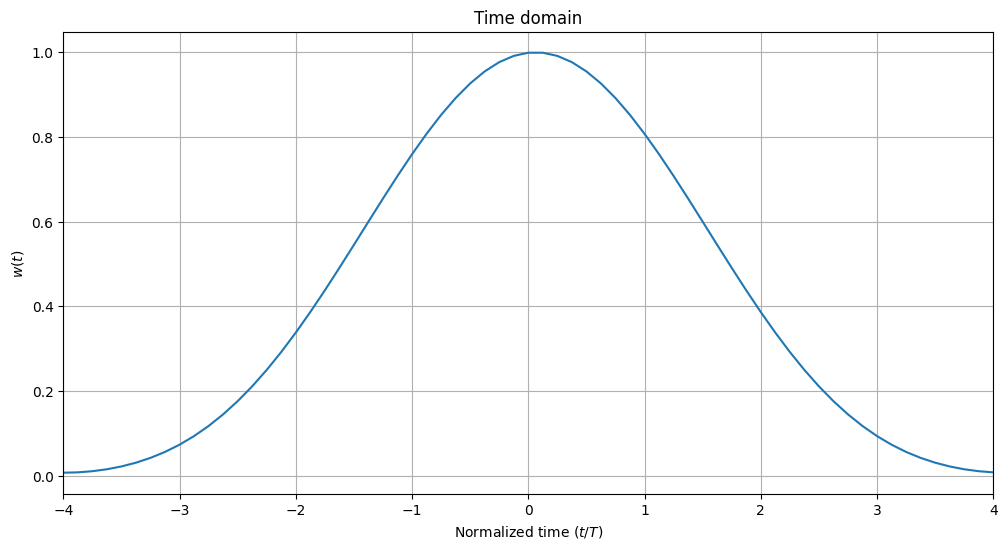

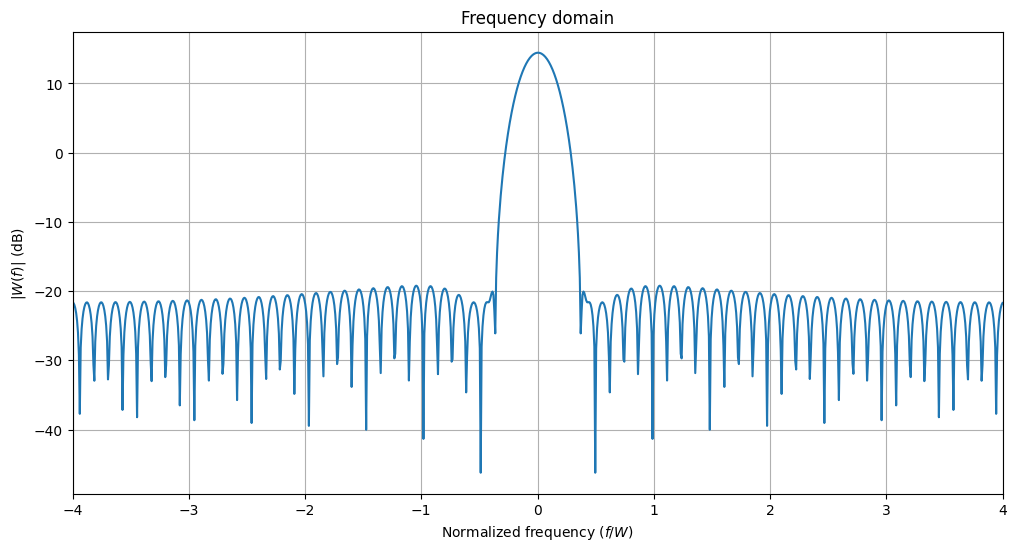

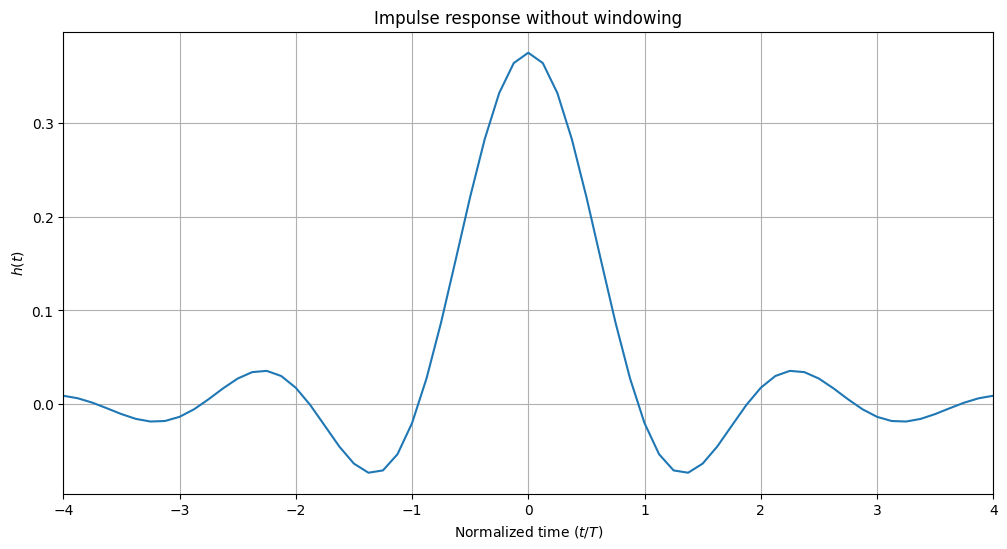

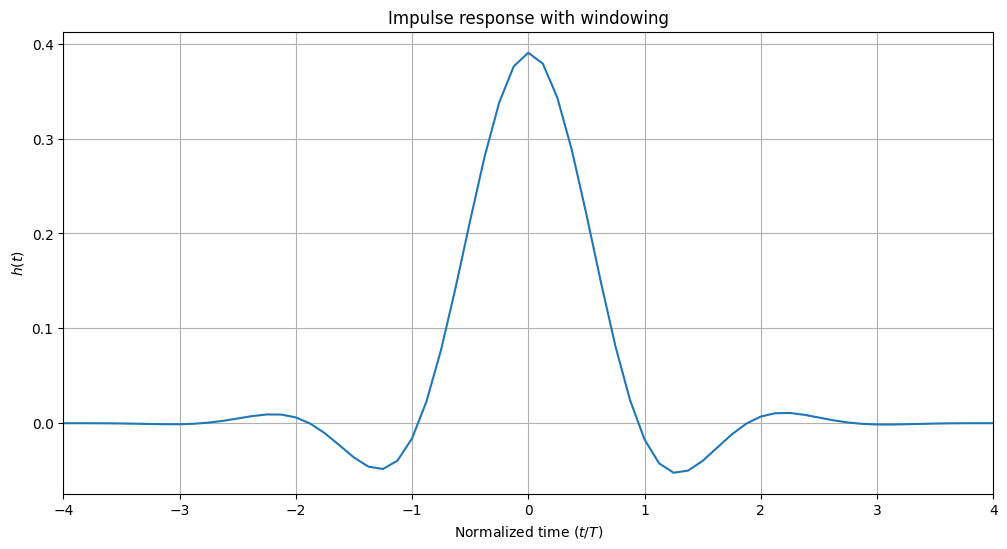

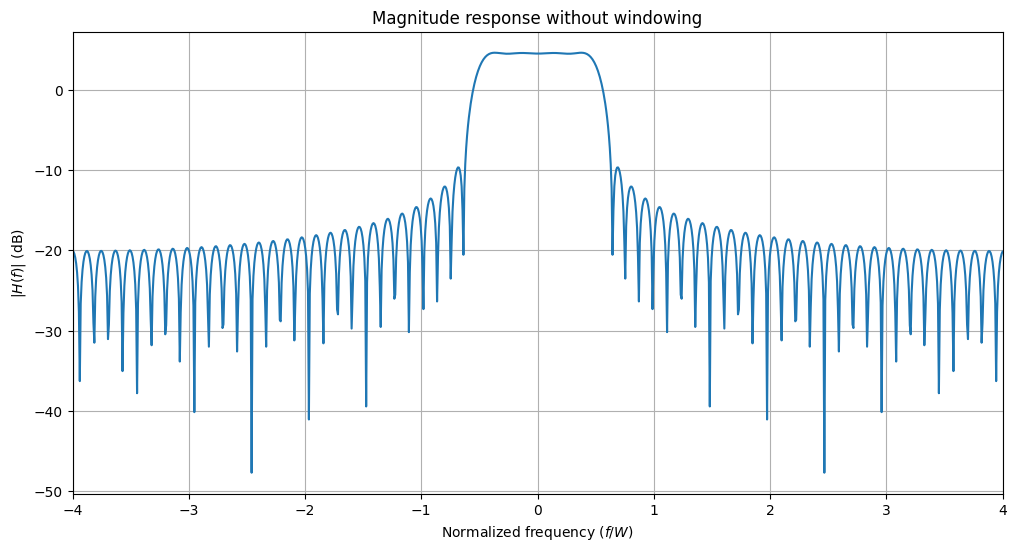

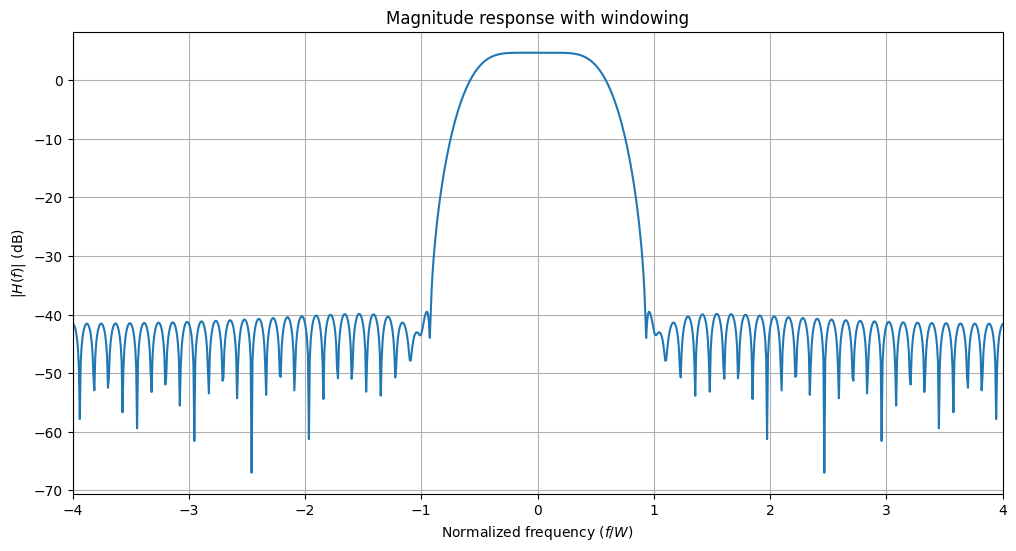

In [14]:
span_in_symbols = 8 # Filter span in symbols
samples_per_symbol = 8 # Number of samples per symbol, i.e., the oversampling factor

rrcf_short = RootRaisedCosineFilter(span_in_symbols, samples_per_symbol, beta)
rrcf_short_blackman = RootRaisedCosineFilter(span_in_symbols, samples_per_symbol, beta, window="blackman")

rrcf_short_blackman.window.show(samples_per_symbol)
rrcf_short_blackman.window.show(samples_per_symbol, domain="frequency", scale="db")

rrcf_short.show()
plt.title("Impulse response without windowing")

rrcf_short_blackman.show()
plt.title("Impulse response with windowing")

rrcf_short.show("magnitude", "db")
plt.title("Magnitude response without windowing")

rrcf_short_blackman.show("magnitude", "db")
plt.title("Magnitude response with windowing")

print("ACLR (db) without window", 10*np.log10(rrcf_short.aclr))
print("ACLR (db) with window", 10*np.log10(rrcf_short_blackman.aclr))